<center>
<h2>DV2599 - PROJECT</h2>
<h3>Predicting Payment date</h3>
<h4>
Rasmus Dunder - radn21@student.bth.se
</h4>
<h4>
Rasmus Johansson - rajo22@student.bth.se
</h4>
</center>

#### Import modules / libraries

In [212]:
import pandas as pd

# Ignore warnings messages in prints
import warnings
warnings.filterwarnings("ignore")

#### Data cleaning

In [213]:
#Importing the dataset
df = pd.read_csv('dataset.csv')

#Dropping not needed columns
df = df.drop(columns=['name_customer', 'buisness_year', 'invoice_currency', 'doc_id','posting_id', 'area_business','document type', 'baseline_create_date', 'document_create_date.1', 'document_create_date'])

# df['invoice_id'] = df['invoice_id'].astype(str)
# Print ratio of open/closed invoices
not_yetpayed = df['isOpen'].value_counts().sort_index()
quality_ratios = round((not_yetpayed / not_yetpayed.sum()),4) * 100
print(f"Ratios: {quality_ratios}")
print(f"Counts: {not_yetpayed}")

# Drop all Columns where invoice is not yet paid

df_predict = df[df['isOpen'] == 1]
df = df[df['isOpen'] == 0]
df_predict = df_predict.drop(columns=['clear_date'])
#Printing the nullvalues in the dataset
print(f"\nNull values in the dataset: {sum(df.isnull().sum(axis=1))}\n")

#Dropping the nullvalues
df.dropna(inplace=True)

#Dropping the duplicates from the datasets
df.drop_duplicates(subset=['invoice_id'], inplace=True)
df_predict.drop_duplicates(subset=['invoice_id'], inplace=True)

#Removing now not needed columns
df = df.drop(columns=['invoice_id', 'isOpen'])
df_predict = df_predict.drop(columns=['invoice_id', 'isOpen'])

#Making all dates the same type
df['due_in_date'] = pd.to_datetime(df['due_in_date'], format='%Y%m%d')
df['clear_date'] = pd.to_datetime(df['clear_date'],  errors='coerce')
df['posting_date'] = pd.to_datetime(df['posting_date'], format='%m/%d/%Y')
df_predict['due_in_date'] = pd.to_datetime(df_predict['due_in_date'], format='%Y%m%d')
df_predict['posting_date'] = pd.to_datetime(df_predict['posting_date'], format='%m/%d/%Y')

# Drop Columns where due_in_date is before posting date
df = df[df['due_in_date'] >= df['posting_date']]
df_predict = df_predict[df_predict['due_in_date'] >= df_predict['posting_date']]

#Creating 3 new columns
df['payment_term'] = (df['due_in_date'] - df['posting_date']).dt.days
df['delayed_payment_days'] = (df['clear_date'] - df['due_in_date']).dt.days
df['payed_on_time'] = df['delayed_payment_days'] <= 0
df_predict['payment_term'] = (df_predict['due_in_date'] - df_predict['posting_date']).dt.days

Ratios: isOpen
0    80.0
1    20.0
Name: count, dtype: float64
Counts: isOpen
0    40000
1    10000
Name: count, dtype: int64

Null values in the dataset: 6



Att tänka på

- Outliers
- Normalisering

In [214]:
from scipy import stats
from sklearn.preprocessing import LabelEncoder

#Checking for ratio on True/False
payed_time = df['payed_on_time'].value_counts().sort_index()
quality_ratios = round((payed_time / payed_time.sum()),4) * 100
print(f"Ratios: {quality_ratios}")
print(f"Counts: {payed_time}")

label_encoder = LabelEncoder()
df['cust_number'] = label_encoder.fit_transform(df['cust_number'])
df_predict['cust_number'] = label_encoder.fit_transform(df_predict['cust_number'])
label_encoder = LabelEncoder()
df['cust_payment_terms'] = label_encoder.fit_transform(df['cust_payment_terms'])
df_predict['cust_payment_terms'] = label_encoder.fit_transform(df_predict['cust_payment_terms'])

label_encoder = LabelEncoder()
df['business_code'] = label_encoder.fit_transform(df['business_code'])
df_predict['business_code'] = label_encoder.fit_transform(df_predict['business_code'])

df_payement_days = df.copy()
df_payement_ontime = df.copy()

df_payement_days = df_payement_days.drop(columns=['payed_on_time','clear_date'])
df_payement_ontime = df_payement_ontime.drop(columns=['delayed_payment_days','clear_date'])

Ratios: payed_on_time
False    41.76
True     58.24
Name: count, dtype: float64
Counts: payed_on_time
False    16308
True     22740
Name: count, dtype: int64


### Splitting and Scaling of the data

In [215]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#df_payement_ontime = df_payement_ontime[df_payement_ontime['business_code'] == 'U013']

label_encoder = LabelEncoder()
df_payement_ontime['payed_on_time'] = label_encoder.fit_transform(df_payement_ontime['payed_on_time'])

# Divide the data into X and y compontents, X being all the attributes and y being the outcome.
X = df_payement_ontime.iloc[:, :-1]
y = df_payement_ontime.iloc[:,-1:]

# Split data
date_X_train, date_X_test, y_train, y_test = train_test_split(X ,y ,test_size = 0.30, random_state=42)
#secs_X_train, secs_X_test, secs_y_train, secs_y_test = train_test_split(X ,y ,test_size = 0.30, random_state=0)
secs_X_train, secs_X_test = date_X_train.copy(), date_X_test.copy()

for col in ['posting_date', 'due_in_date']:
    date_X_train[f'{col}_year'] = date_X_train[col].dt.year
    date_X_train[f'{col}_month'] = date_X_train[col].dt.month
    date_X_train[f'{col}_day'] = date_X_train[col].dt.day

    date_X_test[f'{col}_year'] = date_X_test[col].dt.year
    date_X_test[f'{col}_month'] = date_X_test[col].dt.month
    date_X_test[f'{col}_day'] = date_X_test[col].dt.day

# Drop the original date columns if no longer needed
date_X_train.drop(columns=['posting_date', 'due_in_date'], inplace=True)
date_X_test.drop(columns=['posting_date', 'due_in_date'], inplace=True)

#MIN MAX SCALING
scaler = MinMaxScaler()
columns = ['payment_term', 'total_open_amount']
scaled_values_train = scaler.fit_transform(date_X_train[columns])
scaled_values_test = scaler.transform(date_X_test[columns])

X_train_scaled = date_X_train.copy()
X_test_scaled = date_X_test.copy()

#Add the scaled columns to the DataFrame with new column names
for i, col in enumerate(columns):
    X_train_scaled[f"{col}"] = scaled_values_train[:, i]
    X_test_scaled[f"{col}"] = scaled_values_test[:, i]

secs_X_train['posting_date'] = secs_X_train['posting_date'].astype('int64') // 10**9
secs_X_test['posting_date'] = secs_X_test['posting_date'].astype('int64') // 10**9
secs_X_train['due_in_date'] = secs_X_train['due_in_date'].astype('int64') // 10**9
secs_X_test['due_in_date'] = secs_X_test['due_in_date'].astype('int64') // 10**9



In [216]:
payed_time = y_test['payed_on_time'].value_counts().sort_index()
quality_ratios = round((payed_time / payed_time.sum()),4) * 100
print(f"Ratios: {quality_ratios}")
print(f"Counts: {payed_time}")

Ratios: payed_on_time
0    41.79
1    58.21
Name: count, dtype: float64
Counts: payed_on_time
0    4896
1    6819
Name: count, dtype: int64


### Performing KFold validations tests

##### Dates as month/day/year

In [217]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import RepeatedKFold, cross_val_score

import numpy as np

rkf = RepeatedKFold(n_splits= 2, n_repeats= 5)
date_knn_f1_scores = cross_val_score(KNeighborsClassifier(), X_train_scaled, y_train, cv= rkf, scoring="f1")
date_rdf_f1_scores = cross_val_score(RandomForestClassifier(), X_train_scaled, y_train, cv= rkf, scoring="f1")
date_gdb_f1_scores = cross_val_score(GradientBoostingClassifier(), X_train_scaled, y_train, cv= rkf, scoring="f1")

#Rounds all scores to 4 decimals
for i,x in enumerate(date_gdb_f1_scores):
    date_gdb_f1_scores[i] = round(x,4)

for i,x in enumerate(date_rdf_f1_scores):
    date_rdf_f1_scores[i] = round(x,4)

for i,x in enumerate(date_knn_f1_scores):
    date_knn_f1_scores[i] = round(x,4)

## Calculating mean and standard deviation
date_knn_mean_f1 = round(sum(date_knn_f1_scores)/len(date_knn_f1_scores),4)
date_rdf_mean_f1 = round(sum(date_rdf_f1_scores)/len(date_rdf_f1_scores),4)
date_gdb_mean_f1 = round(sum(date_gdb_f1_scores)/len(date_gdb_f1_scores),4)
date_knn_std_deviation_f1 = round(np.std(date_knn_f1_scores),4)
date_rdf_std_deviation_f1 = round(np.std(date_rdf_f1_scores),4)
date_gdb_std_deviation_f1 = round(np.std(date_gdb_f1_scores),4)

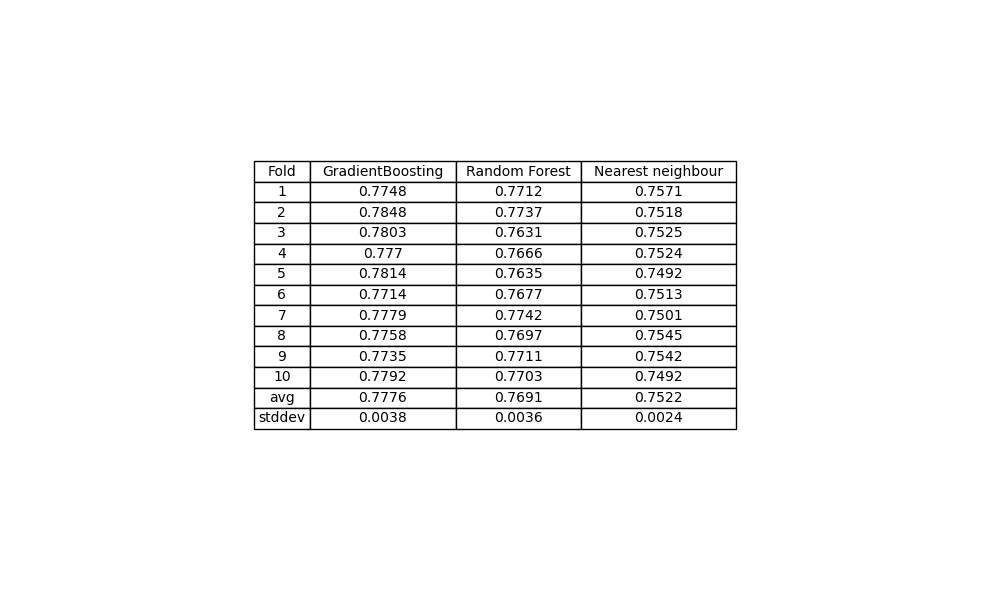

In [218]:
import matplotlib.pyplot as plt

## Making a new Dataframe that looks like table 12.4 in main literature
data = {
    'Fold': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'GradientBoosting': date_gdb_f1_scores,
    'Random Forest': date_rdf_f1_scores,
    'Nearest neighbour': date_knn_f1_scores,
}
avg = ['avg',date_gdb_mean_f1,date_rdf_mean_f1,date_knn_mean_f1]
stddev = ['stddev',date_gdb_std_deviation_f1,date_rdf_std_deviation_f1,date_knn_std_deviation_f1]


plot = pd.DataFrame(data)
plot.loc[len(plot)] = avg
plot.loc[len(plot)] = stddev

## Plot the dataframe as a Table
fig, ax = plt.subplots(figsize=(10, 6))

fig.patch.set_visible(False)
ax.axis('off')
table = ax.table(cellText=plot.values, colLabels=plot.columns, loc='center', cellLoc='center')
fig.tight_layout()
table.auto_set_column_width(col=list(range(len(plot.columns))))

##### Dates as seconds from January 1970

In [219]:
rkf = RepeatedKFold(n_splits= 2, n_repeats= 5)
secs_knn_f1_scores = cross_val_score(KNeighborsClassifier(), secs_X_train, y_train, cv= rkf, scoring="f1")
secs_rdf_f1_scores = cross_val_score(RandomForestClassifier(), secs_X_train, y_train, cv= rkf, scoring="f1")
secs_gdb_f1_scores = cross_val_score(GradientBoostingClassifier(), secs_X_train, y_train, cv= rkf, scoring="f1")

#Rounds all scores to 4 decimals
for i,x in enumerate(secs_gdb_f1_scores):
    secs_gdb_f1_scores[i] = round(x,4)

for i,x in enumerate(secs_rdf_f1_scores):
    secs_rdf_f1_scores[i] = round(x,4)

for i,x in enumerate(secs_knn_f1_scores):
    secs_knn_f1_scores[i] = round(x,4)

## Calculating mean and standard deviation
secs_knn_mean_f1 = round(sum(secs_knn_f1_scores)/len(secs_knn_f1_scores),4)
secs_rdf_mean_f1 = round(sum(secs_rdf_f1_scores)/len(secs_rdf_f1_scores),4)
secs_gdb_mean_f1 = round(sum(secs_gdb_f1_scores)/len(secs_gdb_f1_scores),4)
secs_knn_std_deviation_f1 = round(np.std(secs_knn_f1_scores),4)
secs_rdf_std_deviation_f1 = round(np.std(secs_rdf_f1_scores),4)
secs_gdb_std_deviation_f1 = round(np.std(secs_gdb_f1_scores),4)

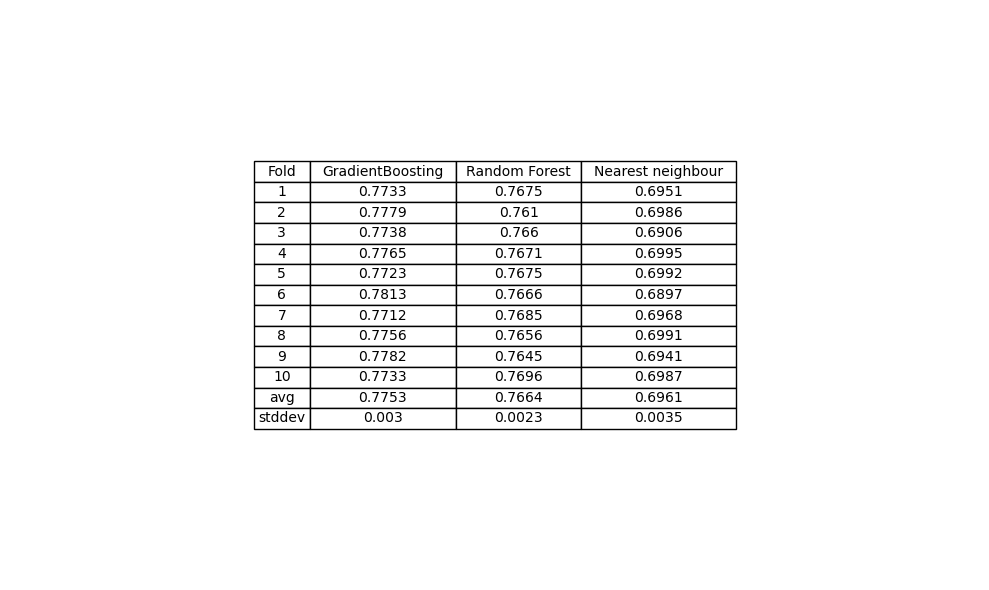

In [220]:
## Making a new Dataframe that looks like table 12.4 in main literature
data = {
    'Fold': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'GradientBoosting': secs_gdb_f1_scores,
    'Random Forest': secs_rdf_f1_scores,
    'Nearest neighbour': secs_knn_f1_scores,
}
avg = ['avg',secs_gdb_mean_f1,secs_rdf_mean_f1,secs_knn_mean_f1]
stddev = ['stddev',secs_gdb_std_deviation_f1,secs_rdf_std_deviation_f1,secs_knn_std_deviation_f1]


plot = pd.DataFrame(data)
plot.loc[len(plot)] = avg
plot.loc[len(plot)] = stddev

## Plot the dataframe as a Table
fig, ax = plt.subplots(figsize=(10, 6))

fig.patch.set_visible(False)
ax.axis('off')
table = ax.table(cellText=plot.values, colLabels=plot.columns, loc='center', cellLoc='center')
fig.tight_layout()
table.auto_set_column_width(col=list(range(len(plot.columns))))

### Ranking the tests and plotting ranktables

##### Dates as month/day/year

In [221]:
ranks = []


## Checking wich algorithms has the highest, middle and lowest value for each fold
for i in range(len(date_knn_f1_scores)):
    
    knn = date_knn_f1_scores[i]
    rdf = date_rdf_f1_scores[i]
    gdb = date_gdb_f1_scores[i]
    
    if knn >= rdf and knn >= gdb:
        knn_rank = 1
        if rdf >= gdb:
            rdf_rank = 2
            gdb_rank = 3
        else:
            rdf_rank = 3
            gdb_rank = 2
    elif rdf >= knn and rdf >= gdb:
        rdf_rank = 1
        if knn >= gdb:
            knn_rank = 2
            gdb_rank = 3
        else:
            knn_rank = 3
            gdb_rank = 2
    else:
        gdb_rank = 1
        if knn >= rdf:
            knn_rank = 2
            rdf_rank = 3
        else:
            knn_rank = 3
            rdf_rank = 2

    ranks.append([gdb_rank,rdf_rank,knn_rank])

## Calculating a average rank

date_avg_knn_f1_scores = 0
date_avg_rdf_f1_scores = 0
date_avg_gdb_f1_scores = 0

for x in ranks:
    date_avg_gdb_f1_scores += x[0]
    date_avg_rdf_f1_scores += x[1]
    date_avg_knn_f1_scores += x[2]

date_avg_gdb_f1_scores = date_avg_gdb_f1_scores/len(ranks)
date_avg_rdf_f1_scores = date_avg_rdf_f1_scores/len(ranks)
date_avg_knn_f1_scores = date_avg_knn_f1_scores/len(ranks)

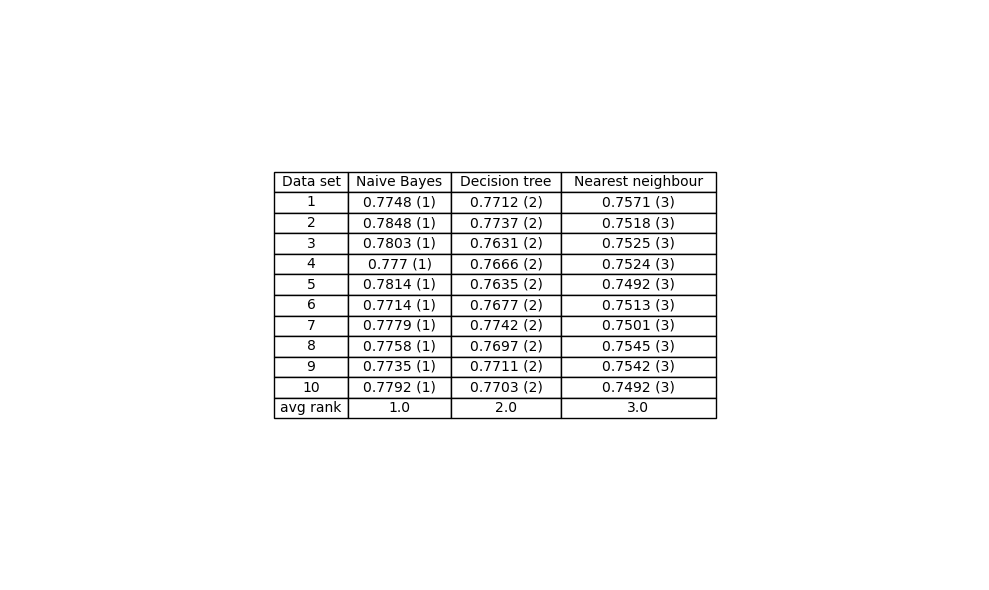

In [222]:
## Making a new Dataframe that looks like table 12.8 in main literature

gdb_string = []
rdf_string = []
knn_string = []

for i in range(len(ranks)):
    gdb_string.append(str(date_gdb_f1_scores[i]) + " (" + str(ranks[i][0]) + ")")
    rdf_string.append(str(date_rdf_f1_scores[i]) + " (" + str(ranks[i][1]) + ")")
    knn_string.append(str(date_knn_f1_scores[i]) + " (" + str(ranks[i][2]) + ")")


data = {
    'Data set': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Naive Bayes': gdb_string,
    'Decision tree': rdf_string,
    'Nearest neighbour': knn_string,
}
avg = ['avg rank',date_avg_gdb_f1_scores,date_avg_rdf_f1_scores,date_avg_knn_f1_scores]

plot = pd.DataFrame(data)
plot.loc[len(plot)] = avg

## Plotting the dataframe as a Table

fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_visible(False)
ax.axis('off')
table = ax.table(cellText=plot.values, colLabels=plot.columns, loc='center', cellLoc='center')
fig.tight_layout()
table.auto_set_column_width(col=list(range(len(plot.columns))))

##### Dates as seconds from January 1970

In [223]:
ranks = []


## Checking wich algorithms has the highest, middle and lowest value for each fold
for i in range(len(secs_knn_f1_scores)):
    
    knn = secs_knn_f1_scores[i]
    rdf = secs_rdf_f1_scores[i]
    gdb = secs_gdb_f1_scores[i]
    
    if knn >= rdf and knn >= gdb:
        knn_rank = 1
        if rdf >= gdb:
            rdf_rank = 2
            gdb_rank = 3
        else:
            rdf_rank = 3
            gdb_rank = 2
    elif rdf >= knn and rdf >= gdb:
        rdf_rank = 1
        if knn >= gdb:
            knn_rank = 2
            gdb_rank = 3
        else:
            knn_rank = 3
            gdb_rank = 2
    else:
        gdb_rank = 1
        if knn >= rdf:
            knn_rank = 2
            rdf_rank = 3
        else:
            knn_rank = 3
            rdf_rank = 2

    ranks.append([gdb_rank,rdf_rank,knn_rank])

## Calculating a average rank

secs_avg_knn_f1_scores = 0
secs_avg_rdf_f1_scores = 0
secs_avg_gdb_f1_scores = 0

for x in ranks:
    secs_avg_gdb_f1_scores += x[0]
    secs_avg_rdf_f1_scores += x[1]
    secs_avg_knn_f1_scores += x[2]

secs_avg_gdb_f1_scores = secs_avg_gdb_f1_scores/len(ranks)
secs_avg_rdf_f1_scores = secs_avg_rdf_f1_scores/len(ranks)
secs_avg_knn_f1_scores = secs_avg_knn_f1_scores/len(ranks)

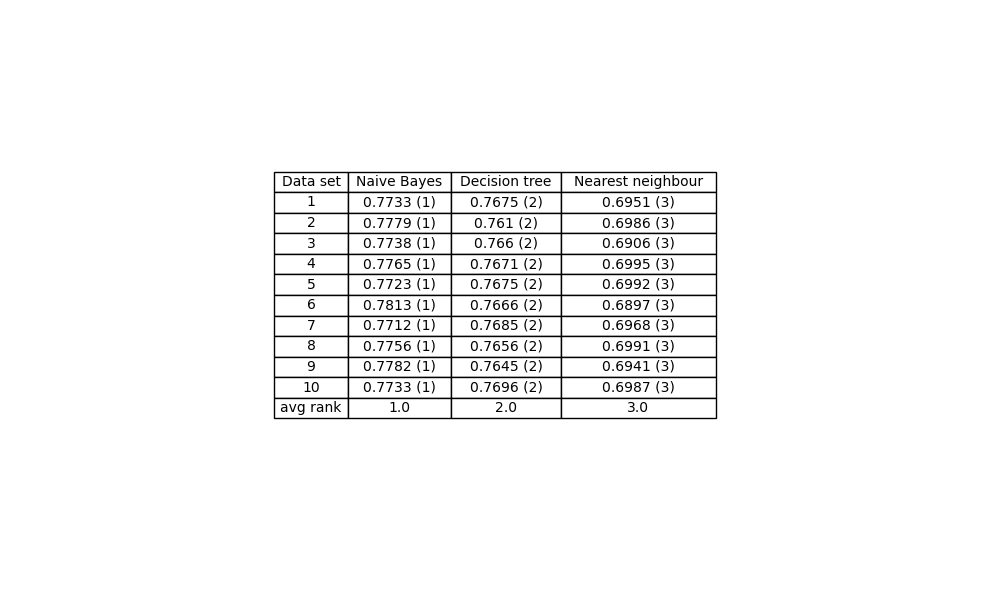

In [224]:
## Making a new Dataframe that looks like table 12.8 in main literature

gdb_string = []
rdf_string = []
knn_string = []

for i in range(len(ranks)):
    gdb_string.append(str(secs_gdb_f1_scores[i]) + " (" + str(ranks[i][0]) + ")")
    rdf_string.append(str(secs_rdf_f1_scores[i]) + " (" + str(ranks[i][1]) + ")")
    knn_string.append(str(secs_knn_f1_scores[i]) + " (" + str(ranks[i][2]) + ")")


data = {
    'Data set': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Naive Bayes': gdb_string,
    'Decision tree': rdf_string,
    'Nearest neighbour': knn_string,
}
avg = ['avg rank',secs_avg_gdb_f1_scores,secs_avg_rdf_f1_scores,secs_avg_knn_f1_scores]

plot = pd.DataFrame(data)
plot.loc[len(plot)] = avg

## Plotting the dataframe as a Table

fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_visible(False)
ax.axis('off')
table = ax.table(cellText=plot.values, colLabels=plot.columns, loc='center', cellLoc='center')
fig.tight_layout()
table.auto_set_column_width(col=list(range(len(plot.columns))))

### Conducting the Friedman and Nemenyi Tests

In [225]:
import math

# Declaring variables
k = 3
n = len(ranks)

## Calculating Friedman formulas
avg_rank = (k+1)/2
sum_sqd_secs = n * ((secs_avg_gdb_f1_scores - avg_rank)**2 + (secs_avg_rdf_f1_scores - avg_rank)**2 + (secs_avg_knn_f1_scores - avg_rank)**2)
sum_sqd_date = n * ((date_avg_gdb_f1_scores - avg_rank)**2 + (date_avg_rdf_f1_scores - avg_rank)**2 + (date_avg_knn_f1_scores - avg_rank)**2)


##Calculating Nemenyia Score
nem_score = 2.343 * (math.sqrt((k*(k+1)/(6*n))))

#Printing the results
print(f"The sum sqared difference for Dates: {sum_sqd_secs}")
print(f"The sum sqared difference for Secs: {sum_sqd_date}")
print(f"The Nemenyi Score: {nem_score}")

# Declaring variables
k = 2
n = len(ranks)

## Calculating Friedman formulas between modules
avg_rank = (k+1)/2
sum_sqd_date = n * ((secs_avg_rdf_f1_scores - avg_rank)**2 + (secs_avg_knn_f1_scores - avg_rank)**2)

##Calculating Nemenyia Score
nem_score = 2.343 * (math.sqrt((k*(k+1)/(6*n))))

print(f"\nThe sum sqared difference between Dates and Secs: {sum_sqd_date}")
print(f"The Nemenyi Score: {nem_score}")

The sum sqared difference for Dates: 20.0
The sum sqared difference for Secs: 20.0
The Nemenyi Score: 1.0478214542564015

The sum sqared difference between Dates and Secs: 25.0
The Nemenyi Score: 0.7409216557774513


### Model Stacking

In [226]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
# Initialize base models
model_a = RandomForestClassifier()
model_b = GradientBoostingClassifier()

# Create placeholders for meta-features
meta_features_train = np.zeros((len(y_train), 2))
meta_features_test = np.zeros((len(y_test), 2))

# Cross-validation for meta-feature generation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(date_X_train):
    # Split training data into folds using .iloc
    fold_X_date_train, fold_X_date_val = date_X_train.iloc[train_idx], date_X_train.iloc[val_idx]
    fold_X_secs_train, fold_X_secs_val = secs_X_train.iloc[train_idx], secs_X_train.iloc[val_idx]
    fold_y_train, fold_y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train base models on fold training data
    model_a.fit(fold_X_date_train, fold_y_train)
    model_b.fit(fold_X_secs_train, fold_y_train)
    
    # Predict on fold validation data and populate meta-features
    meta_features_train[val_idx, 0] = model_a.predict_proba(fold_X_date_val)[:, 1]
    meta_features_train[val_idx, 1] = model_b.predict_proba(fold_X_secs_val)[:, 1]

# Train base models on the full training data
model_a.fit(date_X_train, y_train)
model_b.fit(secs_X_train, y_train)

# Generate meta-features for the test set
meta_features_test[:, 0] = model_a.predict_proba(date_X_test)[:, 1]
meta_features_test[:, 1] = model_b.predict_proba(secs_X_test)[:, 1]

# Train the meta-model using Logistic Regression
meta_model = LogisticRegression()
meta_model.fit(meta_features_train, y_train)

# Evaluate on the test set
final_predictions = meta_model.predict(meta_features_test)

# Metrics
accuracy = round(f1_score(y_test, model_b.predict(secs_X_test)), 4)
accuracy1 = round(f1_score(y_test, model_a.predict(date_X_test)), 4)
accuracy2 = round(f1_score(y_test, final_predictions), 4)
accuracy3 = round(accuracy_score(y_test, final_predictions), 4)

print("Secs model with Gradient Boosting:", accuracy)
print("Date model with Random Forest:", accuracy1)
print("Stacked Model (F1):", accuracy2)
print("Stacked Model (Accuracy):", accuracy3)


Secs model with Gradient Boosting: 0.781
Date model with Random Forest: 0.7808
Stacked Model (F1): 0.7995
Stacked Model (Accuracy): 0.7569


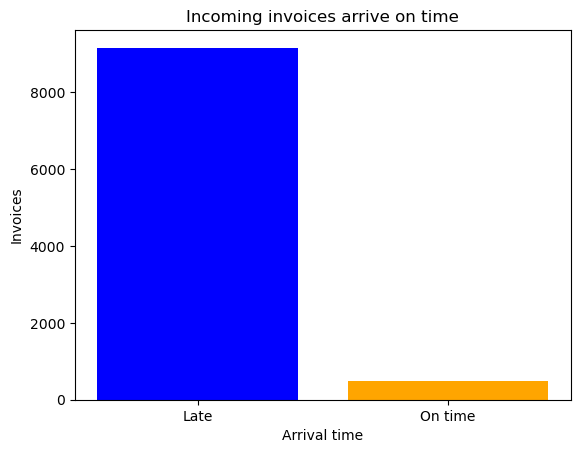

In [262]:
count_0 = np.sum(final_predictions == 0)
count_1 = np.sum(final_predictions == 1)

# Data for the bar chart
labels = ['Late', 'On time']
counts = [count_0, count_1]

# Create the bar chart
plt.bar(labels, counts, color=['blue', 'orange'])

# Add labels and title
plt.xlabel('Arrival time')
plt.ylabel('Invoices')
plt.title('Incoming invoices arrive on time')

# Show the chart
plt.show()

In [228]:
df_predict_date = df_predict.copy()
df_predict_secs = df_predict.copy()

for col in ['posting_date', 'due_in_date']:
    df_predict_date[f'{col}_year'] = df_predict_date[col].dt.year
    df_predict_date[f'{col}_month'] = df_predict_date[col].dt.month
    df_predict_date[f'{col}_day'] = df_predict_date[col].dt.day

# Drop the original date columns if no longer needed
df_predict_date.drop(columns=['posting_date', 'due_in_date'], inplace=True)

#MIN MAX SCALING
scaler = MinMaxScaler()
columns = ['payment_term', 'total_open_amount']
scaled_values_test = scaler.fit_transform(df_predict_date[columns])

#Add the scaled columns to the DataFrame with new column names
for i, col in enumerate(columns):
    df_predict_date[f"{col}"] = scaled_values_test[:, i]

df_predict_secs['posting_date'] = df_predict_secs['posting_date'].astype('int64') // 10**9
df_predict_secs['due_in_date'] = df_predict_secs['due_in_date'].astype('int64') // 10**9

In [229]:
# Predictions for meta-model
pred_a = model_a.predict_proba(df_predict_date)[:, 1]
pred_b = model_b.predict_proba(df_predict_secs)[:, 1]
pred_ab = model_a.predict(df_predict_date)
pred_ba = model_b.predict(df_predict_secs)
stacked_features = np.column_stack((pred_a, pred_b))

# Evaluate
stacked_test_features = np.column_stack((
    model_a.predict_proba(df_predict_date)[:, 1],
    model_b.predict_proba(df_predict_secs)[:, 1]
))
final_predictions = meta_model.predict(stacked_test_features)
final_predictions_ontime = pred_ba
print(final_predictions)

[0 0 0 ... 0 0 0]


In [246]:
# Reset index to ensure clean DataFrames for both training and target
df_predict_date.reset_index(drop=True, inplace=True)

late_invoices = []
for i, x in enumerate(final_predictions_ontime):
    if x == 0:
        late_invoices.append(i)

print(f"\nNumber of late invoices: {len(late_invoices)}")

# Drop the rows corresponding to the outliers from both features and target
df_predict_date = X_train_scaled.drop(index=late_invoices)

# Reset indices after dropping outliers
df_predict_date.reset_index(drop=True, inplace=True)


Number of late invoices: 7481


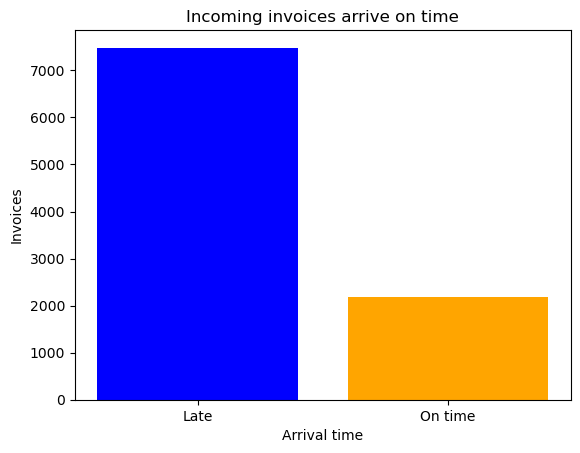

Index(['business_code', 'cust_number', 'total_open_amount',
       'cust_payment_terms', 'payment_term', 'posting_date_year',
       'posting_date_month', 'posting_date_day', 'due_in_date_year',
       'due_in_date_month', 'due_in_date_day'],
      dtype='object')


In [230]:
count_0 = np.sum(final_predictions_ontime == 0)
count_1 = np.sum(final_predictions_ontime == 1)

# Data for the bar chart
labels = ['Late', 'On time']
counts = [count_0, count_1]

# Create the bar chart
plt.bar(labels, counts, color=['blue', 'orange'])

# Add labels and title
plt.xlabel('Arrival time')
plt.ylabel('Invoices')
plt.title('Incoming invoices arrive on time')

# Show the chart
plt.show()
print(df_predict_date.columns)

Random Forest Regressor
Gradient Boosting Regressor (e.g., XGBoost)
Support Vector Regressor (SVR)

Fitted Mean: 0.81
Fitted Standard Deviation: 10.81


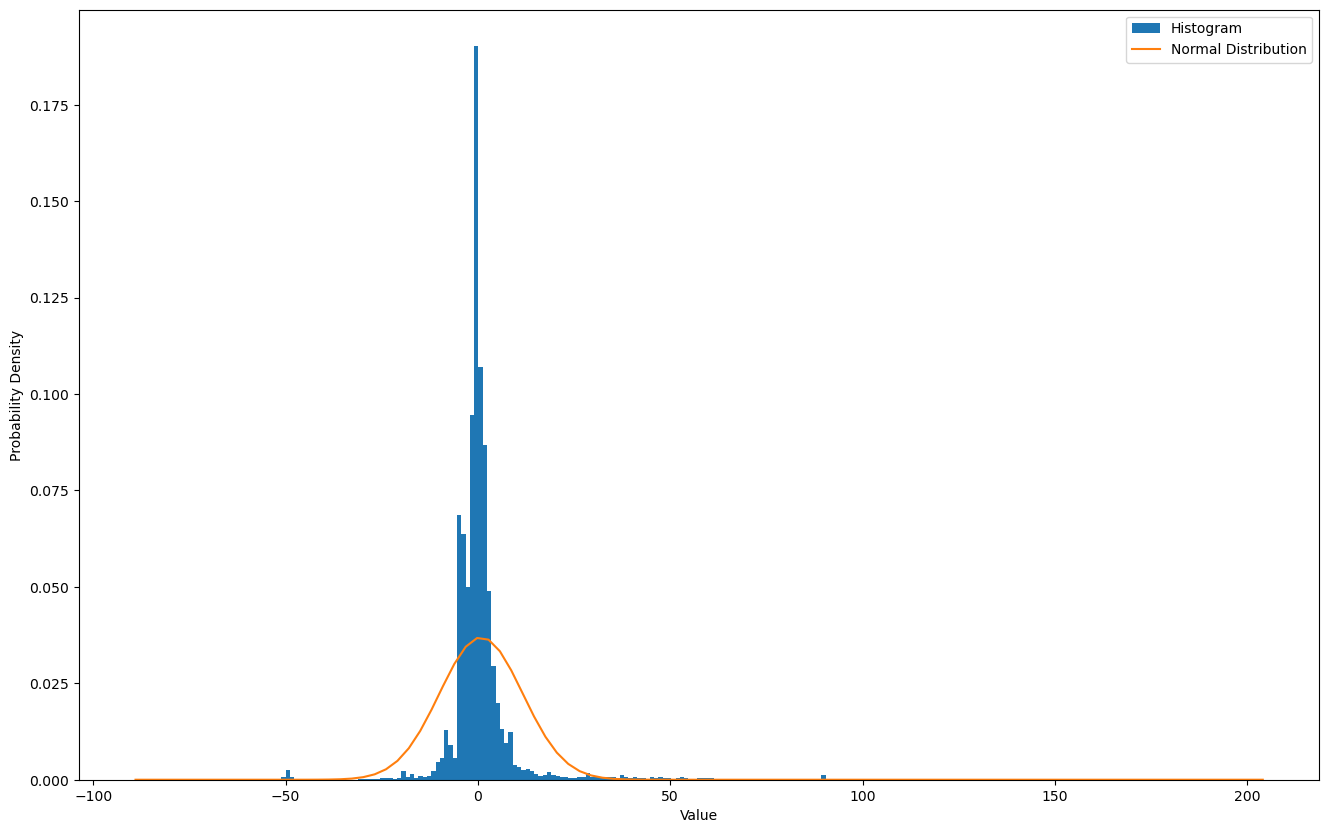

In [231]:
df_payement_dayslow = df_payement_days.copy()
#Calculating the widht size of the bins in the histogram
n = len(df_payement_dayslow['delayed_payment_days'])
bins = np.ceil((max(df_payement_dayslow['delayed_payment_days'])-min(df_payement_dayslow['delayed_payment_days']))/(3.5*np.std(df_payement_dayslow['delayed_payment_days'])/n**(1/3)))

#Plotting the values to a histogram
plt.figure(figsize=(16,10))
plt.hist(df_payement_dayslow['delayed_payment_days'], bins=int(bins), density=True, label="Histogram")

#Calculating Mean and Standard deviation
mean, std_dev = stats.norm.fit(df_payement_dayslow['delayed_payment_days'])
x = np.linspace(min(df_payement_dayslow['delayed_payment_days']), max(df_payement_dayslow['delayed_payment_days']), 100)
p = stats.norm.pdf(x, mean, std_dev)

#Plotting the normal curve 
plt.plot(x, p, label="Normal Distribution")
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
print("Fitted Mean:", round(mean, 2))
print("Fitted Standard Deviation:", round(std_dev,2))

In [254]:

for col in ['posting_date', 'due_in_date']:
    df_payement_dayslow[f'{col}_year'] = df_payement_dayslow[col].dt.year
    df_payement_dayslow[f'{col}_month'] = df_payement_dayslow[col].dt.month
    df_payement_dayslow[f'{col}_day'] = df_payement_dayslow[col].dt.day

##Drop the original date columns if no longer needed
df_payement_dayslow.drop(columns=['posting_date', 'due_in_date'], inplace=True)

df_positive_delaysa = df_payement_dayslow[df_payement_dayslow['delayed_payment_days'] > 0]

# Divide the data into X and y compontents, X being all the attributes and y being the outcome.
X = X = pd.concat([df_payement_dayslow.iloc[:, :5], df_payement_dayslow.iloc[:, 6:]], axis=1)
y = df_payement_days['delayed_payment_days']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X ,y ,test_size = 0.30, random_state=42)

#MIN MAX SCALING
scaler = MinMaxScaler()
columns = ['payment_term', 'total_open_amount']
scaled_values_train = scaler.fit_transform(X_train[columns])
scaled_values_test = scaler.transform(X_test[columns])

# Combine the scaled values back into the DataFrame
X_train_scaled = X_train.copy()  # Copy the original training data
X_test_scaled = X_test.copy()  # Copy the original test data

# Replace the columns with scaled values
for i, col in enumerate(columns):
    X_train_scaled[col] = scaled_values_train[:, i]
    X_test_scaled[col] = scaled_values_test[:, i]

# Reset index to ensure clean DataFrames for both training and target
X_train_scaled.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Calculate z-score for detecting outliers in the target (y_train)
df_zscore = stats.zscore(y_train)
outliers = []

# Identify outliers with a threshold of 2
threshold = 2
for i, x in enumerate(df_zscore):
    if abs(x) > threshold:
        outliers.append(i)

print(f"\nNumber of outliers: {len(outliers)}")

# Drop the rows corresponding to the outliers from both features and target
X_train_nooutlier = X_train_scaled.drop(index=outliers)
y_train_nooutlier = y_train.drop(index=outliers)

# Reset indices after dropping outliers
X_train_nooutlier.reset_index(drop=True, inplace=True)
y_train_nooutlier.reset_index(drop=True, inplace=True)


Number of outliers: 971


Fitted Mean: -0.14
Fitted Standard Deviation: 4.41


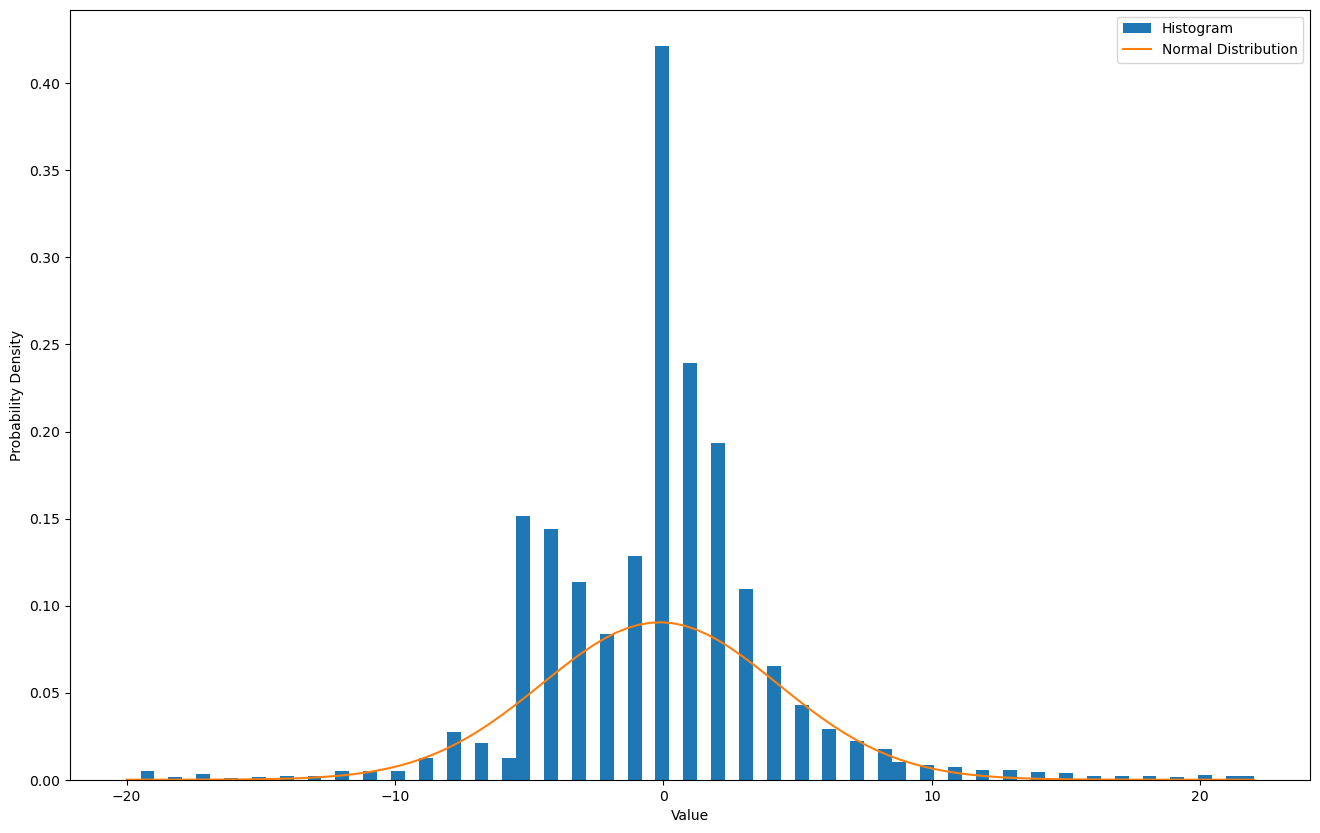

In [233]:
df_payement_dayslow = df_payement_days.copy()
#Calculating the widht size of the bins in the histogram
n = len(y_train_nooutlier)
bins = np.ceil((max(y_train_nooutlier)-min(y_train_nooutlier))/(3.5*np.std(y_train_nooutlier)/n**(1/3)))

#Plotting the values to a histogram
plt.figure(figsize=(16,10))
plt.hist(y_train_nooutlier, bins=int(bins), density=True, label="Histogram")

#Calculating Mean and Standard deviation
mean, std_dev = stats.norm.fit(y_train_nooutlier)
x = np.linspace(min(y_train_nooutlier), max(y_train_nooutlier), 100)
p = stats.norm.pdf(x, mean, std_dev)

#Plotting the normal curve 
plt.plot(x, p, label="Normal Distribution")
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
print("Fitted Mean:", round(mean, 2))
print("Fitted Standard Deviation:", round(std_dev,2))

In [234]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression


skf = StratifiedKFold(n_splits=10)
rfg_accuracy_scores = cross_val_score(RandomForestRegressor(), X_train, y_train, cv= skf, scoring="neg_mean_squared_error")
gbr_accuracy_scores = cross_val_score(GradientBoostingRegressor(), X_train, y_train, cv= skf, scoring="neg_mean_squared_error")
svr_accuracy_scores = cross_val_score(LinearRegression(), X_train, y_train, cv= skf, scoring="neg_mean_squared_error")

#Rounds all scores to 4 decimals
for i,x in enumerate(rfg_accuracy_scores):
    rfg_accuracy_scores[i] = -round(x,4)

for i,x in enumerate(gbr_accuracy_scores):
    gbr_accuracy_scores[i] = -round(x,4)

for i,x in enumerate(svr_accuracy_scores):
    svr_accuracy_scores[i] = -round(x,4)

In [235]:
## Calculating mean and standard deviation
lr_accuracy_scores = svr_accuracy_scores
rfg_mean_accuracy = round(sum(rfg_accuracy_scores)/len(rfg_accuracy_scores),4)
gbr_mean_accuracy = round(sum(gbr_accuracy_scores)/len(gbr_accuracy_scores),4)
lr_mean_accuracy = round(sum(lr_accuracy_scores)/len(lr_accuracy_scores),4)
rfg_std_deviation_accuracy = round(np.std(rfg_accuracy_scores),4)
gbr_std_deviation_accuracy = round(np.std(gbr_accuracy_scores),4)
lr_std_deviation_accuracy = round(np.std(lr_accuracy_scores),4)

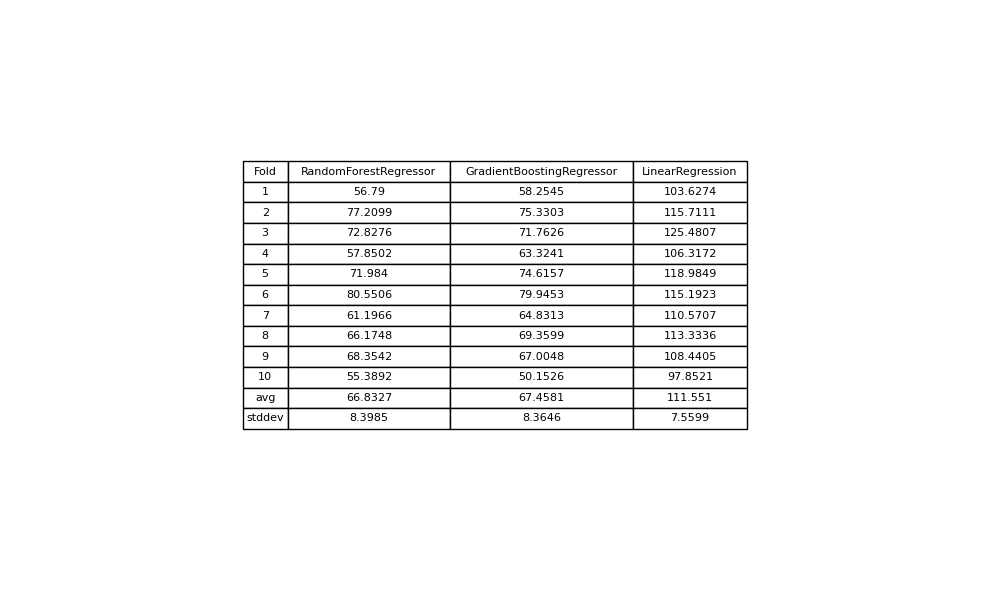

In [236]:
## Making a new Dataframe that looks like table 12.4 in main literature
data = {
    'Fold': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'RandomForestRegressor': rfg_accuracy_scores,
    'GradientBoostingRegressor': gbr_accuracy_scores,
    'LinearRegression': lr_accuracy_scores,
}

avg = ['avg',rfg_mean_accuracy,gbr_mean_accuracy,lr_mean_accuracy]
stddev = ['stddev',rfg_std_deviation_accuracy,gbr_std_deviation_accuracy,lr_std_deviation_accuracy]


plot = pd.DataFrame(data)
plot.loc[len(plot)] = avg
plot.loc[len(plot)] = stddev

## Plot the dataframe as a Table
fig, ax = plt.subplots(figsize=(10, 6))

fig.patch.set_visible(False)
ax.axis('off')
table = ax.table(cellText=plot.values, colLabels=plot.columns, loc='center', cellLoc='center')
fig.tight_layout()
table.auto_set_column_width(col=list(range(len(plot.columns))))

plt.show()

In [237]:
ranks = []


## Checking wich algorithms has the highest, middle and lowest value for each fold
for i in range(len(rfg_accuracy_scores)):
    
    rfg = rfg_accuracy_scores[i]
    gbr = gbr_accuracy_scores[i]
    lr = lr_accuracy_scores[i]
    if rfg <= gbr and rfg <= lr:
        rfg_rank = 1
        if gbr <= lr:
            gbr_rank = 2
            lr_rank = 3
        else:
            gbr_rank = 3
            lr_rank = 2
    elif gbr <= rfg and gbr <= lr:
        gbr_rank = 1
        if rfg <= lr:
            rfg_rank = 2
            lr_rank = 3
        else:
            rfg_rank = 3
            lr_rank = 2
    else:
        lr_rank = 1
        if rfg <= gbr:
            rfg_rank = 2
            gbr_rank = 3
        else:
            rfg_rank = 3
            gbr_rank = 2

    ranks.append([lr_rank,gbr_rank,rfg_rank])

## Calculating a average rank

avg_lr_accuracy = 0
avg_gbr_accuracy = 0
avg_rfg_accuracy = 0

for x in ranks:
    avg_lr_accuracy += x[0]
    avg_gbr_accuracy += x[1]
    avg_rfg_accuracy += x[2]

avg_lr_accuracy = avg_lr_accuracy/len(ranks)
avg_gbr_accuracy = avg_gbr_accuracy/len(ranks)
avg_rfg_accuracy = avg_rfg_accuracy/len(ranks)

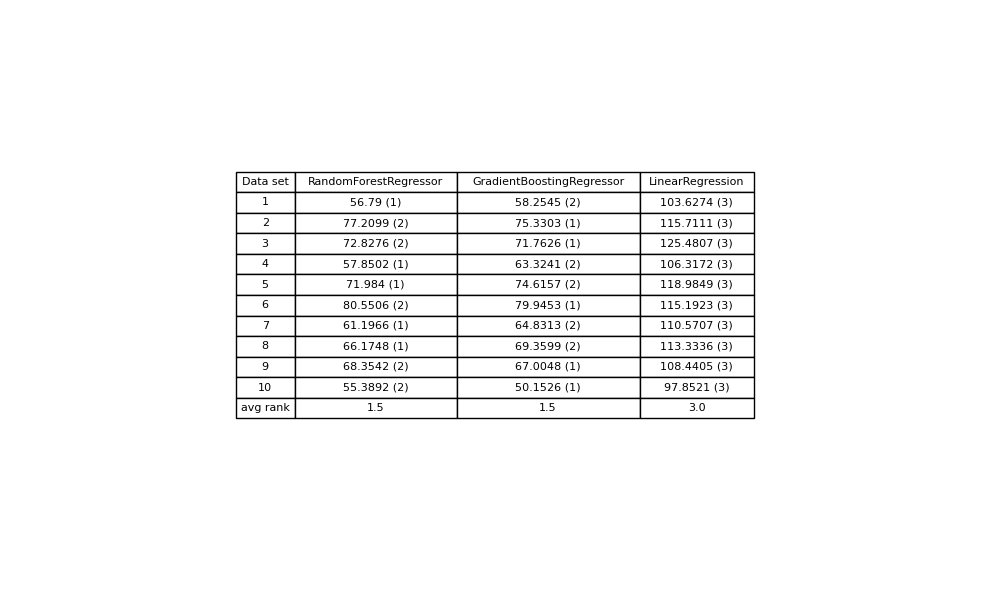

In [238]:
## Making a new Dataframe that looks like table 12.8 in main literature

rfg_string = []
gbr_string = []
lr_string = []

for i in range(len(ranks)):
    rfg_string.append(str(rfg_accuracy_scores[i]) + " (" + str(ranks[i][2]) + ")")
    gbr_string.append(str(gbr_accuracy_scores[i]) + " (" + str(ranks[i][1]) + ")")
    lr_string.append(str(lr_accuracy_scores[i]) + " (" + str(ranks[i][0]) + ")")


data = {
    'Data set': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'RandomForestRegressor': rfg_string,
    'GradientBoostingRegressor': gbr_string,
    'LinearRegression': lr_string,
}
avg = ['avg rank',avg_rfg_accuracy,avg_gbr_accuracy,avg_lr_accuracy]

plot = pd.DataFrame(data)
plot.loc[len(plot)] = avg

## Plotting the dataframe as a Table

fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_visible(False)
ax.axis('off')
table = ax.table(cellText=plot.values, colLabels=plot.columns, loc='center', cellLoc='center')
fig.tight_layout()
table.auto_set_column_width(col=list(range(len(plot.columns))))

In [239]:
import math

# Declaring variables
k = 3
n = len(ranks)

## Calculating Friedman formulas
avg_rank = (k+1)/2
sum_sqd = n * ((avg_rfg_accuracy - avg_rank)**2 + (avg_gbr_accuracy - avg_rank)**2 + (avg_lr_accuracy - avg_rank)**2)

##Calculating Nemenyia Score
nem_score = 2.343 * (math.sqrt((k*(k+1)/(6*n))))

#Printing the results
print(f"The sum sqared difference for Secs: {sum_sqd}")
print(f"The Nemenyi Score: {nem_score}")

The sum sqared difference for Secs: 15.0
The Nemenyi Score: 1.0478214542564015


In [240]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize base models
model_a = RandomForestRegressor()
model_b = GradientBoostingRegressor()
model_ab = RandomForestRegressor()
model_ba = GradientBoostingRegressor()

# Train base models on the full training data
model_a.fit(X_train_nooutlier, y_train_nooutlier)
model_b.fit(X_train_nooutlier, y_train_nooutlier)
model_ab.fit(X_train, y_train)
model_ba.fit(X_train, y_train)

pred_a = model_a.predict(X_test)
pred_b = model_b.predict(X_test)
pred_ab = model_ab.predict(X_test)
pred_ba = model_ba.predict(X_test)

# Metrics
MSEa = round(mean_squared_error(y_test, pred_a), 2)
MSEb = round(mean_squared_error(y_test, pred_b), 2)
MSEab = round(mean_squared_error(y_test, pred_ab), 2)
MSEba = round(mean_squared_error(y_test, pred_ba), 2)

MAEa = round(mean_absolute_error(y_test, pred_a), 2)
MAEb = round(mean_absolute_error(y_test, pred_b), 2)
MAEab = round(mean_absolute_error(y_test, pred_ab), 2)
MAEba = round(mean_absolute_error(y_test, pred_ba), 2)

print("RandomForestRegressor no outliers MSE:", MSEa)
print("RandomForestRegressor no outliers MAE:", MAEa)
print("GradientBoostingRegressor no outliers MSE:", MSEb)
print("GradientBoostingRegressor no outliers MAE:", MAEb)

print("RandomForestRegressor MSE:", MSEab)
print("RandomForestRegressor MAE:", MAEab)
print("GradientBoostingRegressor MSE:", MSEba)
print("GradientBoostingRegressor MAE:", MAEba)

RandomForestRegressor no outliers MSE: 97.55
RandomForestRegressor no outliers MAE: 3.9
GradientBoostingRegressor no outliers MSE: 111.75
GradientBoostingRegressor no outliers MAE: 5.76
RandomForestRegressor MSE: 57.6
RandomForestRegressor MAE: 3.13
GradientBoostingRegressor MSE: 59.93
GradientBoostingRegressor MAE: 3.44


In [257]:
df_positive_delays = df_positive_delaysa.copy()

# Divide the data into X and y compontents, X being all the attributes and y being the outcome.
X = X = pd.concat([df_positive_delays.iloc[:, :5], df_positive_delays.iloc[:, 6:]], axis=1)
y = df_positive_delays['delayed_payment_days']
y_delayed_payment_days = df_positive_delays['delayed_payment_days']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X ,y ,test_size = 0.30, random_state=42)

#MIN MAX SCALING
scaler = MinMaxScaler()
columns = ['payment_term', 'total_open_amount']
scaled_values_train = scaler.fit_transform(X_train[columns])
scaled_values_test = scaler.transform(X_test[columns])

# Combine the scaled values back into the DataFrame
X_train_scaled = X_train.copy()  # Copy the original training data
X_test_scaled = X_test.copy()  # Copy the original test data

# Replace the columns with scaled values
for i, col in enumerate(columns):
    X_train_scaled[col] = scaled_values_train[:, i]
    X_test_scaled[col] = scaled_values_test[:, i]

# Reset index to ensure clean DataFrames for both training and target
X_train_scaled.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Calculate z-score for detecting outliers in the target (y_train)
df_zscore = stats.zscore(y_train)
outliers = []

# Identify outliers with a threshold of 2
threshold = 2
for i, x in enumerate(df_zscore):
    if abs(x) > threshold:
        outliers.append(i)

print(f"\nNumber of outliers: {len(outliers)}")

# Drop the rows corresponding to the outliers from both features and target
X_train_nooutlier = X_train_scaled.drop(index=outliers)
y_train_nooutlier = y_train.drop(index=outliers)

# Reset indices after dropping outliers
X_train_nooutlier.reset_index(drop=True, inplace=True)
y_train_nooutlier.reset_index(drop=True, inplace=True)


Number of outliers: 564


In [242]:
pred_ab = model_ab.predict(X_test)
pred_ba = model_ba.predict(X_test)

for i, x in enumerate(pred_ba):
    if x <= 0:
        pred_ba[i] = 1

for i, x in enumerate(pred_ab):
    if x <= 0:
        pred_ab[i] = 1


# Metrics

MSEab = round(mean_squared_error(y_test, pred_ab), 2)
MSEba = round(mean_squared_error(y_test, pred_ba), 2)
MAEab = round(mean_absolute_error(y_test, pred_ab), 2)
MAEba = round(mean_absolute_error(y_test, pred_ba), 2)

print("RandomForestRegressor MSE:", MSEab)
print("RandomForestRegressor MAE:", MAEab)
print("GradientBoostingRegressor MSE:", MSEba)
print("GradientBoostingRegressor MAE:", MAEba)


RandomForestRegressor MSE: 35.74
RandomForestRegressor MAE: 1.95
GradientBoostingRegressor MSE: 109.62
GradientBoostingRegressor MAE: 3.46


Fitted Mean: 5.5
Fitted Standard Deviation: 11.31


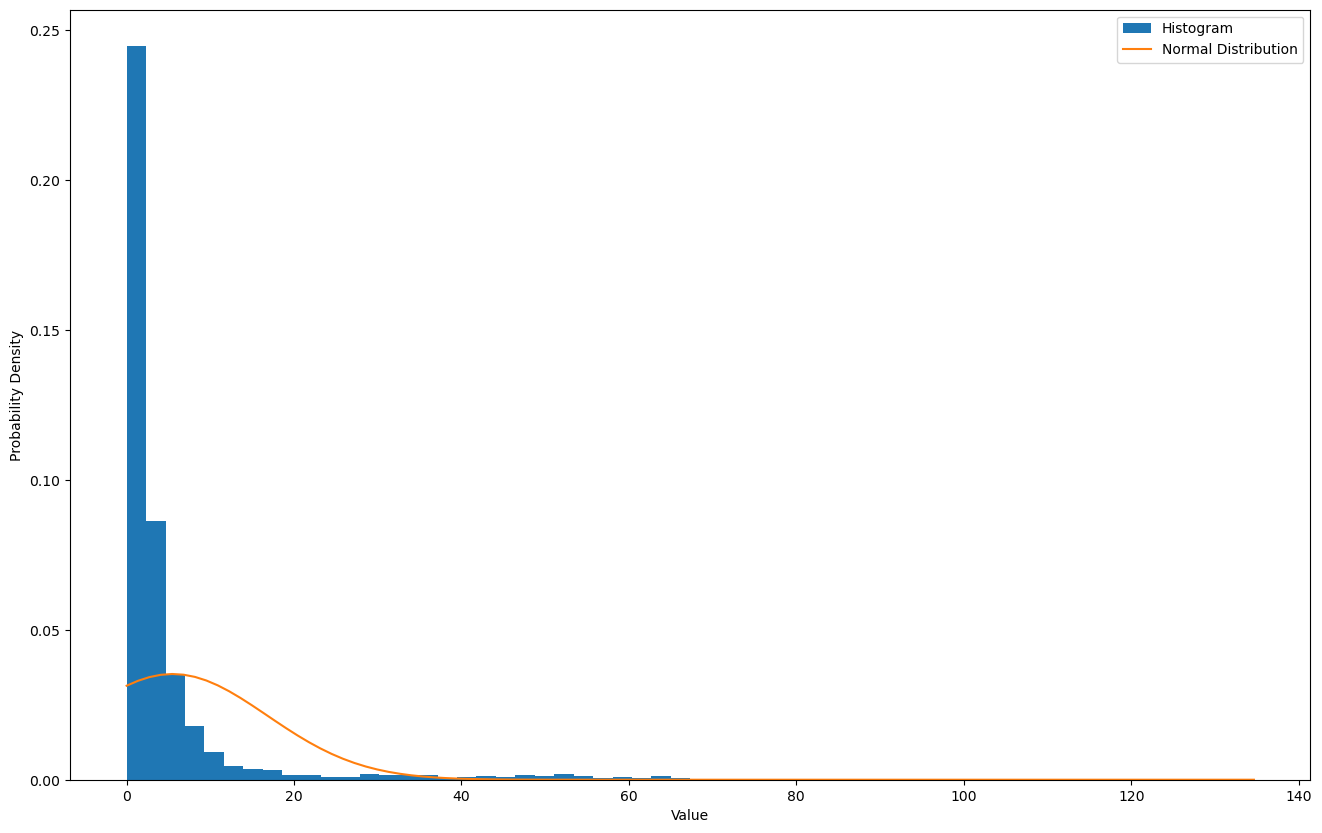

In [243]:
#Calculating the widht size of the bins in the histogram
n = len(pred_ab)
bins = np.ceil((max(pred_ab)-min(pred_ab))/(3.5*np.std(pred_ab)/n**(1/3)))

#Plotting the values to a histogram
plt.figure(figsize=(16,10))
plt.hist(pred_ab, bins=int(bins), density=True, label="Histogram")

#Calculating Mean and Standard deviation
mean, std_dev = stats.norm.fit(pred_ab)
x = np.linspace(min(pred_ab), max(pred_ab), 100)
p = stats.norm.pdf(x, mean, std_dev)

#Plotting the normal curve 
plt.plot(x, p, label="Normal Distribution")
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
print("Fitted Mean:", round(mean, 2))
print("Fitted Standard Deviation:", round(std_dev,2))

Fitted Mean: 6.49
Fitted Standard Deviation: 13.68


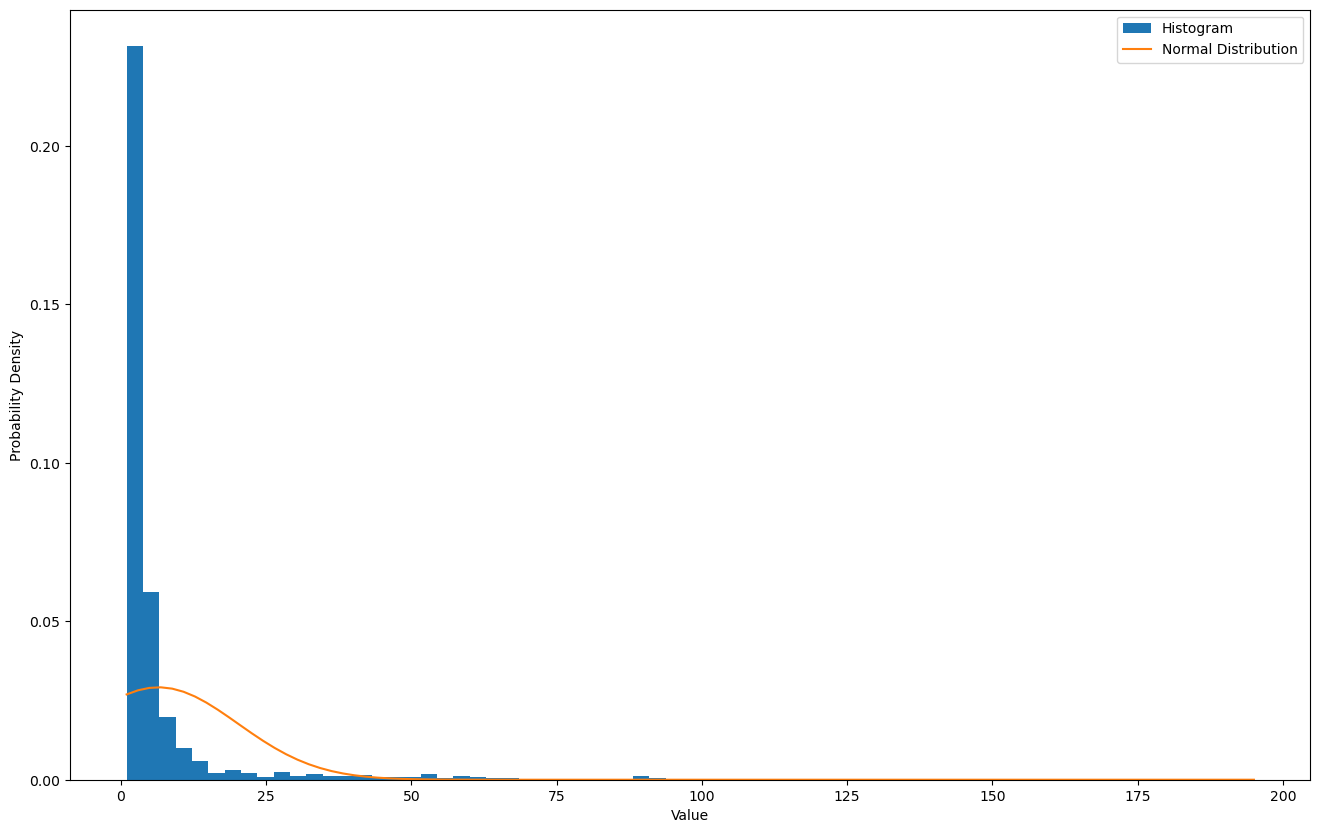

In [244]:
#Calculating the widht size of the bins in the histogram
n = len(y_test)
bins = np.ceil((max(y_test)-min(y_test))/(3.5*np.std(y_test)/n**(1/3)))

#Plotting the values to a histogram
plt.figure(figsize=(16,10))
plt.hist(y_test, bins=int(bins), density=True, label="Histogram")

#Calculating Mean and Standard deviation
mean, std_dev = stats.norm.fit(y_test)
x = np.linspace(min(y_test), max(y_test), 100)
p = stats.norm.pdf(x, mean, std_dev)

#Plotting the normal curve 
plt.plot(x, p, label="Normal Distribution")
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
print("Fitted Mean:", round(mean, 2))
print("Fitted Standard Deviation:", round(std_dev,2))

In [247]:
pred_ab = model_ab.predict(df_predict_date)

for i, x in enumerate(pred_ab):
    if x <= 0:
        pred_ab[i] = 1

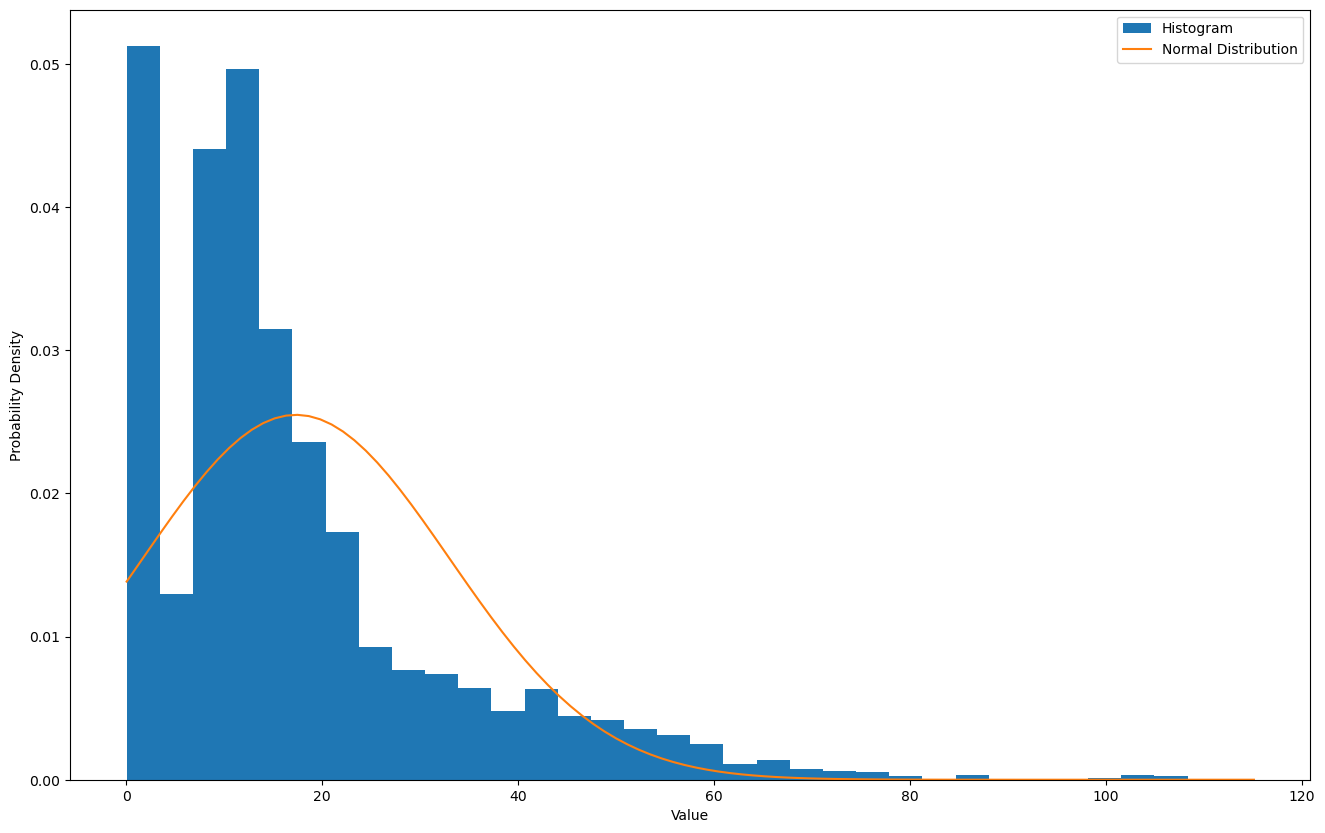

In [249]:
#Calculating the widht size of the bins in the histogram
n = len(pred_ab)
bins = np.ceil((max(pred_ab)-min(pred_ab))/(3.5*np.std(pred_ab)/n**(1/3)))

#Plotting the values to a histogram
plt.figure(figsize=(16,10))
plt.hist(pred_ab, bins=int(bins), density=True, label="Histogram")

#Calculating Mean and Standard deviation
mean, std_dev = stats.norm.fit(pred_ab)
x = np.linspace(min(pred_ab), max(pred_ab), 100)
p = stats.norm.pdf(x, mean, std_dev)

#Plotting the normal curve 
plt.plot(x, p, label="Normal Distribution")
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()

In [261]:
## Calculating mean and standard deviation
pred_ab_mean = round(sum(pred_ab)/len(pred_ab),4)
pred_ab_std_deviation = round(np.std(pred_ab),4)
y_delayed_payment_days_mean = round(sum(y)/len(y),4)
y_delayed_payment_days_std_deviation = round(np.std(y),4)


print("Mean predicted days late on not payed invoices:", pred_ab_mean)
print("Standard deviation on predicted not payed invoices:", pred_ab_std_deviation)
print("Mean days late on late payed invoices:", y_delayed_payment_days_mean)
print("Standard deviation on late payed invoices:", y_delayed_payment_days_std_deviation)

Mean predicted days late on not payed invoices: 17.3191
Standard deviation on predicted not payed invoices: 15.6535
Mean days late on late payed invoices: 6.4467
Standard deviation on late payed invoices: 13.1339
